# Figure 6: Similarity between *wild-type* and *rd10* quality index (QI)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

# ------------------------------------------------------------------------------------------------------------

# load and clean dataset

In [2]:
file_path = 'ADD_YOUR_PATH_TO_DATA_HERE'

rd10_df = pd.read_pickle(file_path)  
# multiindex df to single index df
rd10_df = rd10_df.reset_index(level=[0,1,2,3,4,5,6,7,8,9,10,11])
# drop unnecessary keys
rd10_df = rd10_df.drop(columns=['training_data_hash','classifier_params_hash','preprocess_id','condition','raw_id','gchirp','bar'])
missing_genline_idx = np.where(rd10_df['genline']=='')[0]
rd10_df['genline'][missing_genline_idx]='rd10'
#exclude P60 data
idx_p60 = np.where(rd10_df['animrem'].values=='P60')[0]
rd10_df = rd10_df.drop(idx_p60)
rd10_df = rd10_df.reset_index(drop=True)

/tmp/ipykernel_6831/660621704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rd10_df['genline'][missing_genline_idx]='rd10'


In [3]:
# exclude classified cells below threshold
confidence_score = 0.25
rd10_df = rd10_df[rd10_df['max_confidence']>=confidence_score]

# ------------------------------------------------------------------------------------------------------------

# Compute JSD of the QI's per stimulus

In [4]:
def compute_kde(data, bw_method=None):
    # Add a small amount of noise to avoid singular matrix errors
    data += np.random.normal(0, 1e-9, data.shape)
    kde = gaussian_kde(data, bw_method=bw_method)
    return kde

def compute_jsd(p, q):
    
    if (p.shape[0]<=2) or (q.shape[0]<=2):
        jsd=0
        
    else:
    
        # Compute the KDE for both distributions
        kde_p = compute_kde(p)
        kde_q = compute_kde(q)

        # Define the support for the KDE
        xmin = min(np.min(p), np.min(q))
        xmax = max(np.max(p), np.max(q))
        support = np.linspace(xmin, xmax, 1000)

        # Evaluate the KDE on the support
        pdf_p = kde_p(support)
        pdf_q = kde_q(support)

        # Compute the average PDF
        avg_pdf = 0.5 * (pdf_p + pdf_q)

        # Compute the JSD
        jsd = np.sqrt(0.5 * (jensenshannon(pdf_p, avg_pdf) + jensenshannon(pdf_q, avg_pdf)))
    
    return jsd

In [5]:
type_id = np.hstack((np.arange(1,33,1),np.arange(1,33,1),np.arange(1,33,1)))
jsd_qi_chirp = np.zeros((3,32))
jsd_qi_bar = np.zeros((3,32))

for i in range(0,32):
    qi_chirp_wt_p30 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P30')]['gchirp_qidx'].values
    qi_chirp_rd_p30 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P30')]['gchirp_qidx'].values
    qi_chirp_wt_p45 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P45')]['gchirp_qidx'].values
    qi_chirp_rd_p45 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P45')]['gchirp_qidx'].values
    qi_chirp_wt_p90 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P90')]['gchirp_qidx'].values
    qi_chirp_rd_p90 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P90')]['gchirp_qidx'].values
    jsd_qi_chirp[0,i] = compute_jsd(qi_chirp_wt_p30, qi_chirp_rd_p30)
    jsd_qi_chirp[1,i] = compute_jsd(qi_chirp_wt_p45, qi_chirp_rd_p45)
    jsd_qi_chirp[2,i] = compute_jsd(qi_chirp_wt_p90, qi_chirp_rd_p90)    
    
    qi_bar_wt_p30 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P30')]['bar_d_qi'].values
    qi_bar_rd_p30 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P30')]['bar_d_qi'].values
    qi_bar_wt_p45 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P45')]['bar_d_qi'].values
    qi_bar_rd_p45 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P45')]['bar_d_qi'].values
    qi_bar_wt_p90 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'Bl6') & (rd10_df['animrem'] == 'P90')]['bar_d_qi'].values
    qi_bar_rd_p90 = rd10_df[(rd10_df['celltype'] == i + 1) & (rd10_df['genline'] == 'rd10') & (rd10_df['animrem'] == 'P90')]['bar_d_qi'].values
    jsd_qi_bar[0,i] = compute_jsd(qi_bar_wt_p30, qi_bar_rd_p30)
    jsd_qi_bar[1,i] = compute_jsd(qi_bar_wt_p45, qi_bar_rd_p45)
    jsd_qi_bar[2,i] = compute_jsd(qi_bar_wt_p90, qi_bar_rd_p90)     

In [6]:
jsd_qi_chirp_all = np.hstack((jsd_qi_chirp[0,:],jsd_qi_chirp[1,:],jsd_qi_chirp[2,:]))
jsd_qi_bar_all = np.hstack((jsd_qi_bar[0,:],jsd_qi_bar[1,:],jsd_qi_bar[2,:]))

d = {'JSD': jsd_qi_chirp_all, 'age': ['P30'] * 32 + ['P45'] * 32 + ['P90'] * 32, 'RGC type':type_id}
df_jsd_qi_chirp_all = pd.DataFrame(data=d)

d = {'JSD': jsd_qi_bar_all, 'age': ['P30'] * 32 + ['P45'] * 32 + ['P90'] * 32, 'RGC type':type_id}
df_jsd_qi_bar_all = pd.DataFrame(data=d)

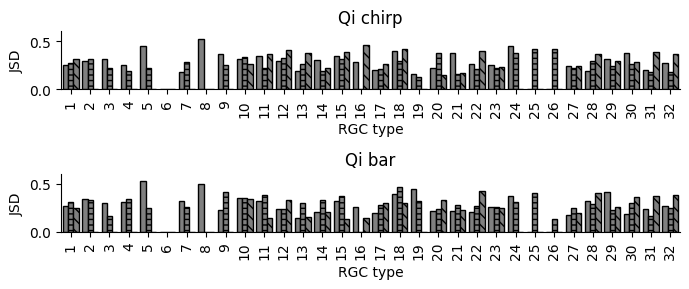

In [7]:
fig,ax=plt.subplots(2,1,figsize=(7,3))

axes1 = sns.barplot(data=df_jsd_qi_chirp_all,
            x='RGC type',
            y='JSD',
            hue='age',
            ax=ax[0],
            edgecolor='k',
            palette=['gray','gray','gray'])

axes2 = sns.barplot(data=df_jsd_qi_bar_all,
            x='RGC type',
            y='JSD',
            hue='age',
            ax=ax[1],
            edgecolor='k',
            palette=['gray','gray','gray'])

     
for item in axes1.get_xticklabels():
    item.set_rotation(90)
for item in axes2.get_xticklabels():
    item.set_rotation(90)

    
ax[0].get_legend().set_visible(False)
ax[1].get_legend().set_visible(False)


ax[0].set_title('Qi chirp')
ax[1].set_title('Qi bar')

ax[0].set_ylim(0,0.6)
ax[1].set_ylim(0,0.6)



hatches = ['', '-', '\\']  # Hatching patterns for each age group
for hatch_pattern, these_bars in zip(hatches, ax[0].containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * hatch_pattern)
for hatch_pattern, these_bars in zip(hatches, ax[1].containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * hatch_pattern) 

sns.despine()
fig.tight_layout()